In [1]:
import quandl
import pandas as pd
import numpy as np
import datetime
from sklearn.neural_network import MLPRegressor
from sklearn import preprocessing, cross_validation, svm
from sklearn.metrics import r2_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
quandl.ApiConfig.api_key = "Hyqv1_kd5xeAzSemDUeH"
%matplotlib inline

/home/aleespa/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [19]:
ticker = "FB"

In [20]:
df = quandl.get("WIKI/"+ticker)

In [21]:
func = ['mean','std','skew','kurt']
time = [2,4,7,30,60,120,252]
k = df.shape[0]-252
Z = pd.DataFrame()
for f in func:
    for t in time:
        aux = pd.DataFrame()
        for i in range(252):
            aux[df.index[i+k-1]] = list(df.iloc[i+k-t:i+k]['Adj. Close'])
        Z[f+str(t)] = aux.apply(f,axis=0)
Z.tail()

,mean2,mean4,mean7,mean30,mean60,mean120,mean252,std2,std4,std7,...,skew60,skew120,skew252,kurt2,kurt4,kurt7,kurt30,kurt60,kurt120,kurt252
2018-03-20,170.355,177.4150,180.070000,179.494663,181.628665,178.847166,166.974642,3.118341,8.363709,6.834930,...,-0.144945,-0.001660,-0.445737,NaN,-4.562880,-0.055596,-0.130105,-0.351294,-0.192548,-1.058916
2018-03-21,168.770,173.7975,177.874286,178.963997,181.494332,178.890333,167.091508,0.876812,7.753973,7.512387,...,-0.248975,0.095125,-0.452864,NaN,2.782997,-2.357637,-0.309441,-0.301967,-0.368518,-1.039785
2018-03-22,167.140,168.7475,175.447143,178.454330,181.289165,178.867083,167.196190,3.181981,3.172027,8.659528,...,-0.502335,0.036720,-0.453418,NaN,0.756437,-2.398149,0.068362,0.201186,-0.254383,-1.028673
2018-03-23,162.140,165.4550,171.904286,178.049000,181.012498,178.789249,167.274762,3.889087,4.466568,9.517142,...,-0.929780,-0.217111,-0.450439,NaN,0.282622,-0.971947,1.575229,1.461309,0.454714,-1.021263
2018-03-26,159.725,163.4325,168.504286,177.518333,180.719832,178.699666,167.356230,0.473762,4.666607,8.754846,...,-1.081208,-0.399189,-0.447256,NaN,-1.828191,1.598181,0.993298,1.546074,0.818447,-1.014162


In [32]:
df[['Adj. Close']].shift(-1)
W = pd.merge(Z, df[['Adj. Close']].shift(-1),left_index=True,right_index=True)
X = W.drop(['Adj. Close'],1).fillna(0)
y = W[['Adj. Close']]

In [27]:
mm = MinMaxScaler()
mm.fit(X)
Xs = pd.DataFrame(mm.transform(X))
Xt, Xv, yt, yv = cross_validation.train_test_split(Xs, y, test_size = 0.3)

(175, 28)


In [85]:
model = MLPRegressor()
param_grid = dict(
activation = ['identity', 'logistic', 'tanh', 'relu'],
solver = ['lbfgs', 'sgd', 'adam'],
learning_rate = ['constant', 'invscaling', 'adaptive'],)
grid = GridSearchCV(cv = 3, 
                    estimator = model,
                    n_jobs = -1,
                    param_grid=param_grid,)
grid.fit(Xs,y)

/home/aleespa/anaconda2/lib/python2.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/aleespa/anaconda2/lib/python2.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


GridSearchCV(cv=3, error_score='raise',
       estimator=MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'learning_rate': ['constant', 'invscaling', 'adaptive'], 'activation': ['identity', 'logistic', 'tanh', 'relu'], 'solver': ['lbfgs', 'sgd', 'adam']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [86]:
model = grid.best_estimator_
model.fit(Xt,yt)

print 'ACC Validate {:.2%}'.format(model.score(Xv,yv))
print 'ACC Train    {:.2%}'.format(model.score(Xt,yt))

ACC Validate 95.39%
ACC Train    97.62%


In [87]:
model.fit(Xs,y)

MLPRegressor(activation='identity', alpha=0.0001, batch_size='auto',
       beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='invscaling',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='lbfgs', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

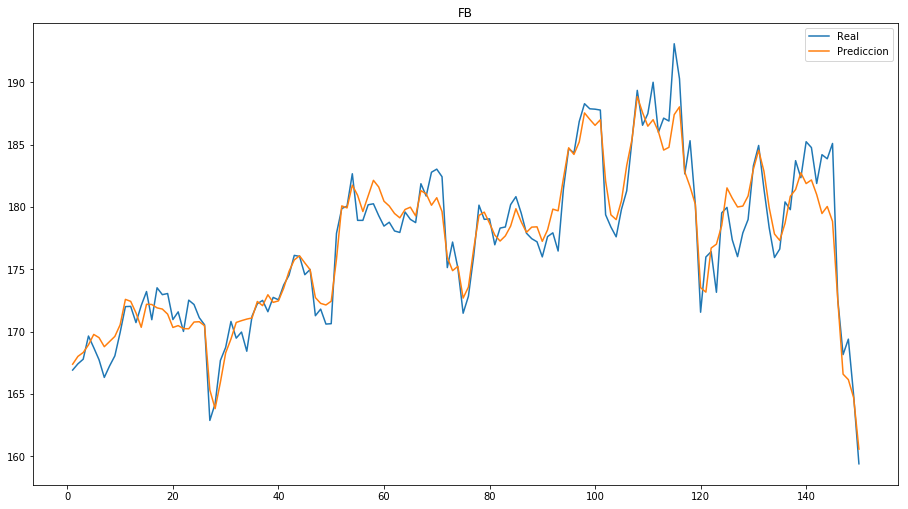

In [88]:
pred = model.predict(Xs[-150:])
x = range(1,151)
plt.plot(x, list(y['Adj. Close'][-151:-1]), label='Real')
plt.plot(x, pred, label='Prediccion')
plt.title(ticker)
plt.legend()
fig = plt.gcf()
fig.set_size_inches(15.5, 8.5)
#plt.savefig(ticker+".png", format="png",)